# Predict yet to arrive 

The notebook shows how to prepare a model that will predict the number of patients yet to arrive.

Inputs
- A series of times in the day at which we want to make these predictions is set, saved in an array called prediction_times. Each prediction time is saved as a tuple. Eg 6 am is saved as (6,0)
- A series of dates on which we want to make these predictions
- A window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths, and load data

In [30]:
import pandas as pd
from patientflow.load import load_data
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name)

# load data
inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


In [31]:
inpatient_arrivals.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2031-04-24 19:21:00+00:00,M,haem/onc,False
1,train,2031-04-25 12:42:00+00:00,F,medical,False
2,train,2031-03-20 19:54:00+00:00,F,haem/onc,False
3,train,2031-03-04 22:03:00+00:00,F,haem/onc,False
4,train,2031-03-01 11:10:44+00:00,M,surgical,False


## Separate into training, validation and test sets


In [32]:
from patientflow.prepare import create_temporal_splits

train_visits, valid_visits, test_visits = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [7730, 1244, 3701]


The Weighted Poisson model requires as input a dataframe with the index set as the arrival datetimes of each visit. We set that here

In [33]:
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)
inpatient_arrivals.set_index('arrival_datetime', inplace=True)

## Train the Weighted Poisson model

The weighted Poisson model provides a way to predict yet to arrive patients under the assumption that the ED/SDEC is meeting targets for how long it takes to admit patients. The aspirational targets are set as parameters in config.yaml and have been loaded at the top of this notebook. 

To load the parameters:

In [34]:
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]
prediction_times = params["prediction_times"]


In [35]:
print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as a curve to see the shape of the curve. Here we have assumed that the majority of admissions happen between 3 and 4 hours of arrival, where the slope of the curve is steepest. 

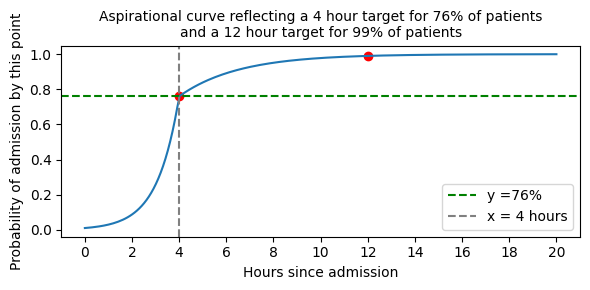

In [36]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
)


### Predict for all admissions, irrespective of specialty of admission

In [55]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from joblib import dump, load

model =  WeightedPoissonPredictor(verbose=True)

model.fit(inpatient_arrivals, prediction_window, yta_time_interval, prediction_times)

model_name = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / model_name 
full_path = full_path.with_suffix('.joblib')

dump(model, full_path)

Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/Users/zellaking/Repos/patientflow/trained-models/public/ed_yet_to_arrive_all_8_hours.joblib']

To see the predicted distribution of patients yet-to-arrive at 15:30, call the model as follows:

In [56]:
prediction_time = tuple([15, 30])

In [61]:
prediction_context = {
    'default': {
        'prediction_time': prediction_time
    }
}

model_name = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / model_name 
full_path = full_path.with_suffix('.joblib')

model = load(full_path)

preds = model.predict(prediction_context, x1, y1, x2, y2)
preds

{'default':      agg_proba
 sum           
 0     0.000044
 1     0.000445
 2     0.002232
 3     0.007455
 4     0.018677
 ..         ...
 252   0.000000
 253   0.000000
 254   0.000000
 255   0.000000
 256   0.000000
 
 [257 rows x 1 columns]}

To make this more readable:

In [58]:
yta_prob_dist = preds['default'].rename(columns = {'agg_proba': 'probability'})
yta_prob_dist.index.name = 'number of beds'

print(f"Probability of needing this number of beds needed at {prediction_time} based on patients yet to arrive ED at that time")
display(yta_prob_dist.head(15))

Probability of needing this number of beds needed at (15, 30) based on patients yet to arrive ED at that time


,probability
number of beds,
0,0.000044
1,0.000445
2,0.002232
3,0.007455
4,0.018677
5,0.037433
6,0.062521
7,0.089505
8,0.112120


To see the output visually we can plot this using the prob_dist_plot from the `viz` module

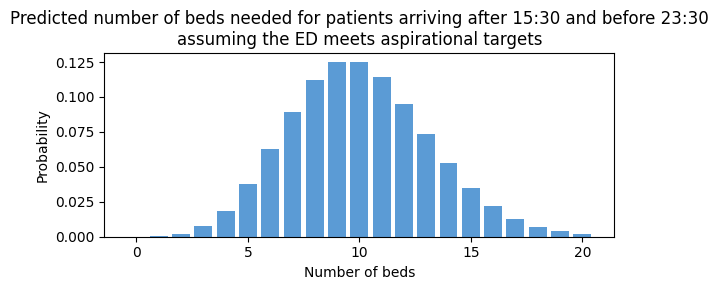

In [59]:
from patientflow.viz.prob_dist_plot import prob_dist_plot

hour, minute = prediction_context['default']['prediction_time']
start_time = f"{hour:02}:{minute:02}"
end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

title = f"Predicted number of beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

prob_dist_plot(preds['default'], 
               title=title, 
               include_titles=True)

If the model is asked to predict for a time it hasn't been trained for (eg 14:30) it will revert to the most recent prediction time. (Note the warning message below.)

In [62]:
prediction_context = {
    'default': {
        'prediction_time': tuple([14,30])
    }
}

model_name = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / model_name 
full_path = full_path.with_suffix('.joblib')

model = load(full_path)

preds = model.predict(prediction_context, x1, y1, x2, y2)


/Users/zellaking/Repos/patientflow/src/patientflow/predictors/weighted_poisson_predictor.py:210: UserWarning: Time of day requested of (14, 30) was not in model training. Reverting to predictions for (12, 0).
  warnings.warn(


### Predict within specialty

To train a model of yet-to-arrive patients within specialty, we can use filters as shown below. Here, if an arrival is a child, we assume they will be admitted to a paediatric specialty by default

In [75]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from joblib import dump, load

specialty_filters = {
    'medical': {'specialty': 'medical', 'is_child': False},
    'surgical': {'specialty': 'surgical', 'is_child': False},
    'haem/onc': {'specialty': 'haem/onc', 'is_child': False},
    'paediatric': {'is_child': True}  # Pediatric doesn't filter by observed_specialty
}

model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters, verbose=True)

model_by_spec.fit(inpatient_arrivals, prediction_window, yta_time_interval, prediction_times)


model_name = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / model_name 
full_path = full_path.with_suffix('.joblib')

dump(model_by_spec, full_path)

Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Inferring number of days from dataset
Calculating time-varying arrival rates for data provided, which spans 306 unique dates
Poisson Binomial Predictor trained for these times: [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]
using prediction window of 480 minutes after the time of prediction
and time interval of 15 minutes within the prediction window.
The error value for prediction will be 1e-07
To see the weights saved by this model, used the get_weights() method


['/Users/zellaking/Repos/patientflow/trained-models/public/ed_yet_to_arrive_by_spec_8_hours.joblib']

In [76]:
model_name = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / model_name 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

prediction_context = {
    'medical': {
        'prediction_time': tuple(prediction_time)  
    }
}

preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)


yta_prob_dist_medical = preds['medical'].rename(columns = {'agg_proba': 'probability'})
yta_prob_dist_medical.index.name = 'number of beds'

print(f"Probability of needing this number of medical beds in the next 8 hours after {prediction_time} for patients yet to arrive at the ED")
display(yta_prob_dist_medical.head(15))

Probability of needing this number of medical beds in the next 8 hours after (15, 30) for patients yet to arrive at the ED


,probability
number of beds,
0,0.004695
1,0.025170
2,0.067471
3,0.120579
4,0.161616
5,0.173295
6,0.154848
7,0.118599
8,0.079481


Plotting the predicted number of beds needed

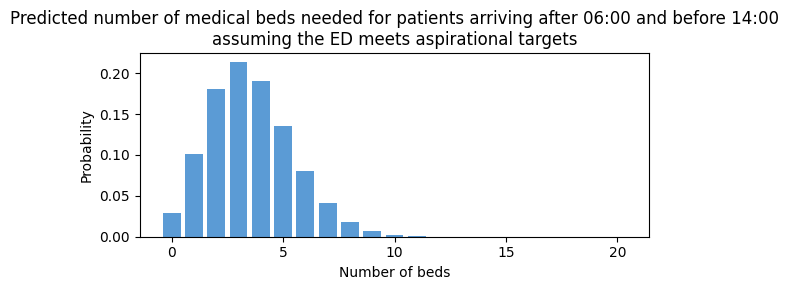

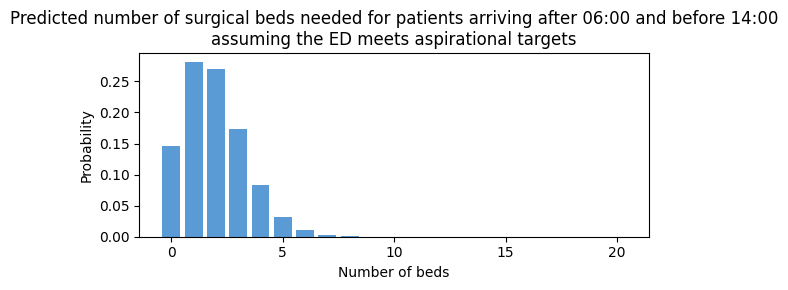

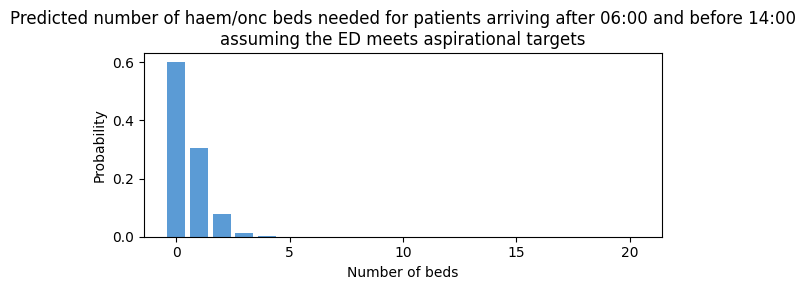

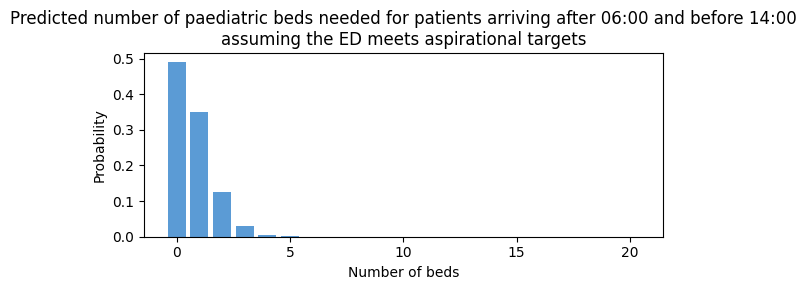

In [77]:
from patientflow.viz.prob_dist_plot import prob_dist_plot

for spec in specialty_filters:
    prediction_context = {
    spec: {
        'prediction_time': tuple([6, 0])  
        }
    }

    preds = model_by_spec.predict(prediction_context, x1, y1, x2, y2)

    hour, minute = prediction_context[spec]['prediction_time']
    start_time = f"{hour:02}:{minute:02}"
    end_time = f"{int(hour + prediction_window / 60):02}:{minute:02}"

    title = f"Predicted number of {spec} beds needed for patients arriving after {start_time} and before {end_time}\nassuming the ED meets aspirational targets"

    prob_dist_plot(preds[spec], 
                title=title, 
                include_titles=True) 